Clasificador codigo ejemplo estructurado

# Clasificador de datos que permita reconocer la marcha

## 0. Initial Setup (carga de libreriías)

In [8]:
# Actualizar ciervo
! pip install ciervo --upgrade


[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from ciervo.plots import emg_plot
from ciervo.io import example_marcha


from scipy import signal
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import numpy as np


# Classifiers
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import pandas as pd

## 1. Data Loading

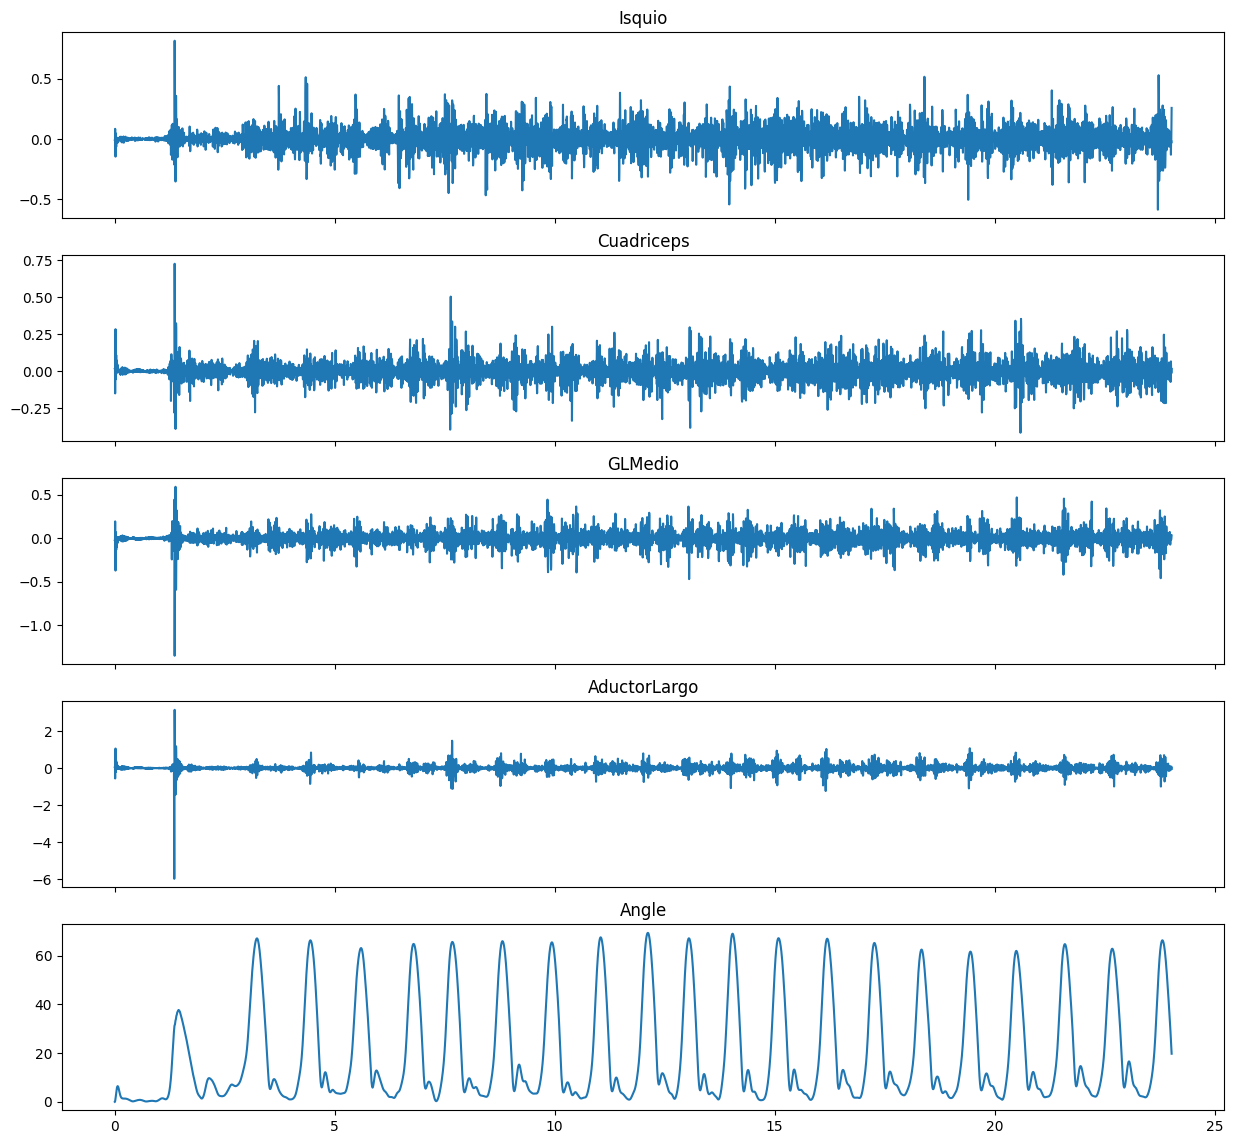

In [10]:
data  = example_marcha()[0] # 17 dataframes con data
len(data)
emg_plot(data)

Dataframe en pandas
 
Elapsed Time: Tiempo en segundos 

- **Isquio:** Señal EMG del músculo isquiotibial 
- **Cuadriceps:** Señal EMG del músculo cuádriceps 
- **GLMedio:** Señal EMG del músculo glúteo medio 
- **AductorLargo:** Señal EMG del músculo aductor largo 
- **Angle** 

## 2. Feature Extraction (funcion extraccion caracteristicas del 100% de los datos)

### 2.1. Downsampling and feature extraction from EMG signals

#### 2.1.1. Identifica y visualizar picos en señal de angulo de la marcha

Se usa find_peaks para identificar picos en la señal de angulo de los datos de marcha. 

Retorna peaks[0], con indices de los picos encontrados en la señal de angulo. Como también se realiza una figura para visualizar los picos detectados.

[ 808 1112 1399 1698 1918 2203 2484 2761 3029 3263 3511 3772 4049 4317
 4585 4863 5123 5399 5669 5954]


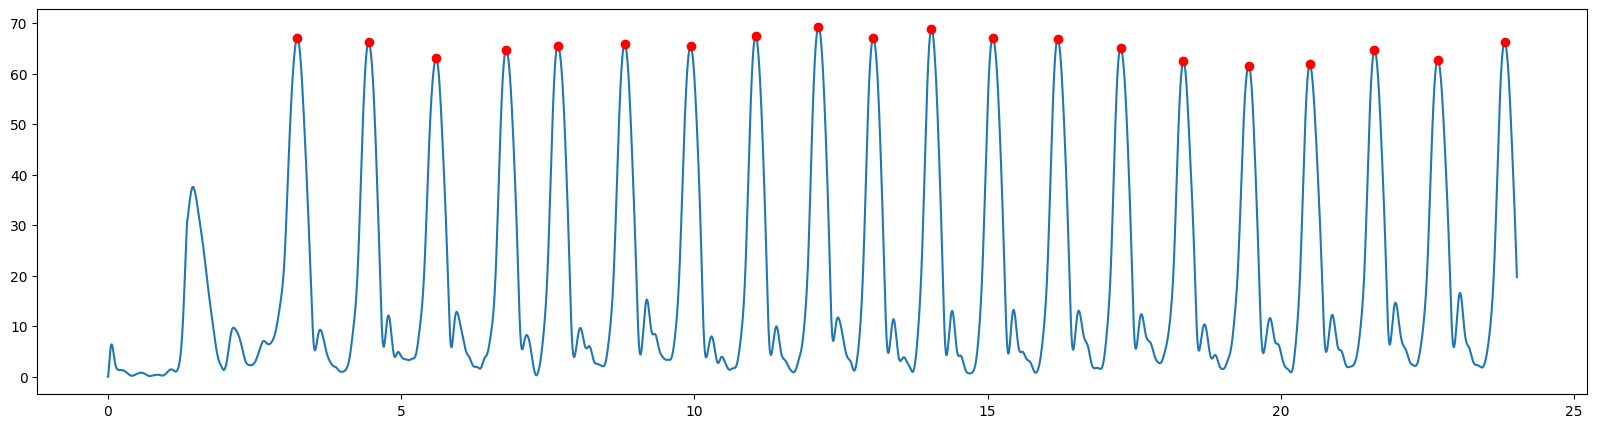

In [11]:
peaks = find_peaks(data['Angle'], height=50, distance=125, width=20)
print(peaks[0])
#figura
fig = plt.figure(figsize=(20, 5))
plt.plot(data['Elapsed Time'], data['Angle'])
plt.plot(peaks[0]/250, data['Angle'][peaks[0]], 'ro') 
plt.show()

#### 2.1.2. Visualizar segmentos de la señal de angulo correspondientes a los ciclos de marcha detectados entre los picos

Cada segmento se grafica sobre el mismo eje para comparar visualmente los diferentes ciclos de marcha. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


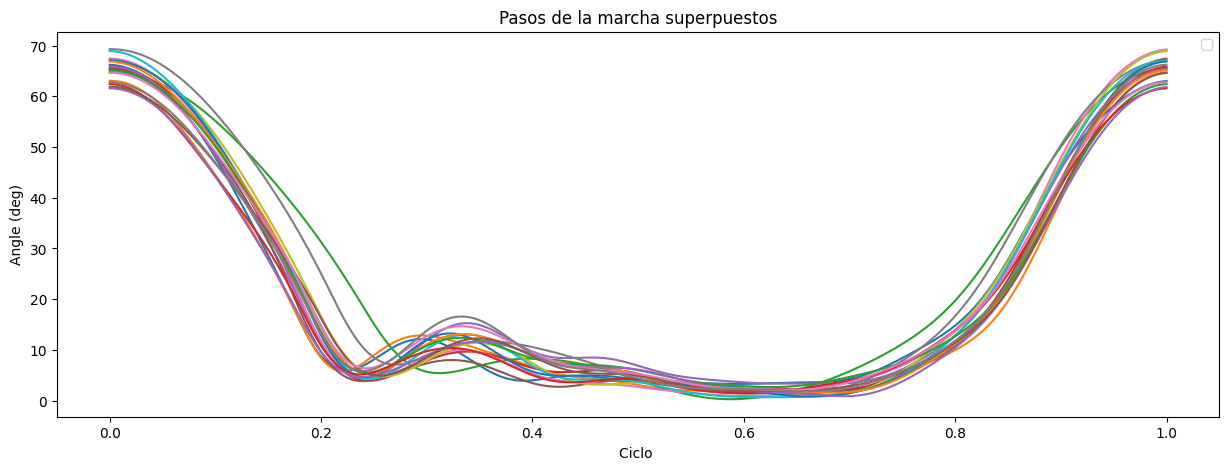

In [12]:
step = [] #almacena segmentos de la señal de angulo

# extrae segmentos de la señal basados en los picos
for i in range(1, len(peaks[0])-1):
    step.append(np.array(data['Angle'][peaks[0][i]:peaks[0][i+1]]))   

# creacion figura para visualizar
fig = plt.figure(figsize=(15, 5))

#grafico cada segmento de la marcha
for i in range(len(step)):
    t = np.linspace(0, 1, len(step[i]))
    plt.plot(t, step[i])

plt.xlabel('Ciclo ')
plt.ylabel('Angle (deg)')
plt.legend()
plt.title('Pasos de la marcha superpuestos')
plt.show()

## 3. Training and testing subsets (definir conjuntos de training y testing)

### 3.1. Split data into training and testing sets

In [13]:
# Definicion muscles
muscles = data.columns[1:-1]   #columnas del df de musculos en datos de EMG

# Inicializar listas
step = [] #pasos
emg = []  #ventanas de EMG normalizadas
file = [] #indice del archivo de origen de cada paso

# Itero sobre archivos de datos
for index, data in enumerate(example_marcha()):

    # Deteccion de picos en la señal de angulo (altura min, distancia min entre picos, ancho min del pico)
    peaks = find_peaks(data['Angle'], height=50, distance=125, width=20)

    # Extraccion y Normalizacion de ventanas de datos
    for i in range(1, len(peaks[0])-1):
        step.append(np.array(data['Angle'][peaks[0][i]:peaks[0][i+1]]))
        emg_window = data[muscles][peaks[0][i]:peaks[0][i+1]].reset_index(drop=True)
        emg_window = np.array(emg_window)

        # normalize
        emg_window = (emg_window - emg_window.mean())/emg_window.std() # asegura media 0 y std 1 de los datos
        emg.append(emg_window) # un paso normalizado de la marcha
        file.append(index) # archivo al que pertenece el paso

# Convertir de file a un array de numpy
file = np.array(file)

### 3.2. Visualizar datos EMG por 4 musculos diferentes

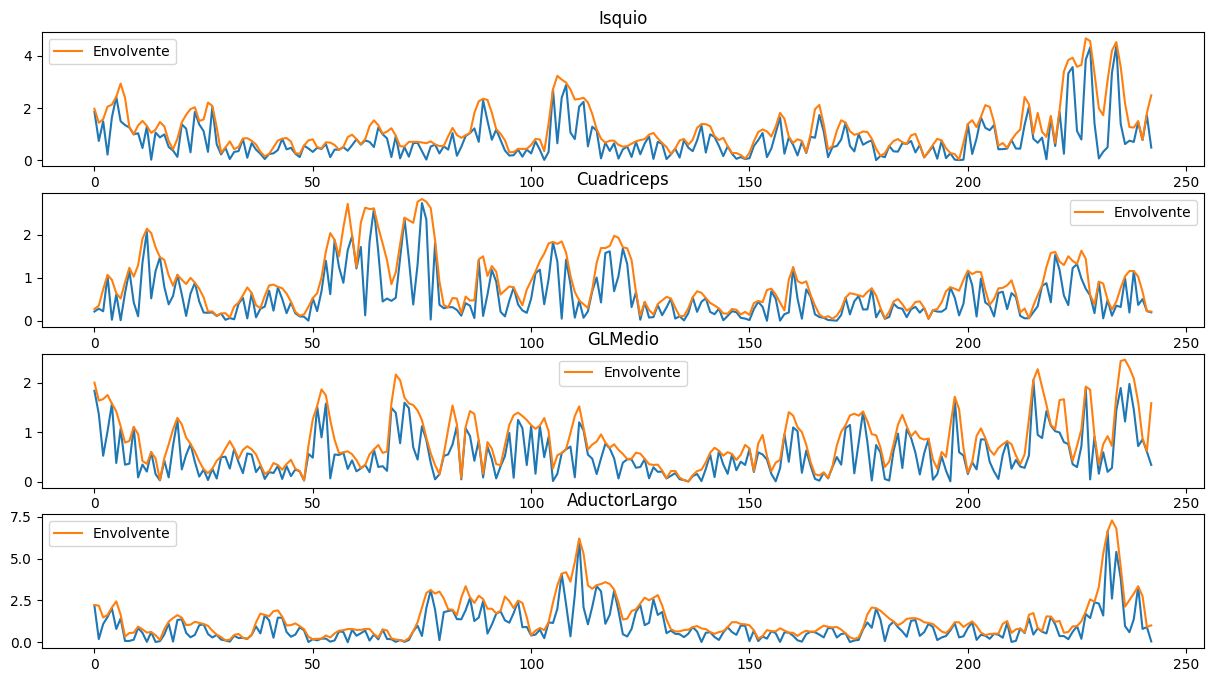

In [14]:
fig,ax = plt.subplots(4, 1, figsize=(15, 8))

# itero sobre ejes para graficar
for i in range(4):
    #grafico señal con rectificacion de onda completa
    ax[i].plot(np.abs(emg_window[:, i]))  # Señal con full wave rectification 
    
    # Calculo de la envolvente usando transformada de hilbert
    env = np.abs(signal.hilbert(emg_window[:, i]))
    ax[i].plot(env, label='Envolvente')
    ax[i].set_title(muscles[i])
    ax[i].legend()

plt.show()

### 3.3. Define feature extraction function


Extraer caracteristicas de datos de EMG

In [15]:
def extract_feature(data, C=[0], divide=3):
    # Full wave rectification
    # data : (T, 4) 
    # T numero de muestras, 4 canales de EMG
    # C numero de indices de canales a usar
    # divide: divide la señal en partes iguales
    result = []
    for c in C:
        env = np.abs(signal.hilbert(data[:, c]))
        for i in range(divide):
            start = int(i*len(data)/divide)
            end = int((i+1)*len(data)/divide)
            promedio  =env[start:end].mean()
            result.append(promedio)
    result = np.array(result)
    return result

# itera sobre datos (division en fases, extrae caract para cada fase, etiquetado)
# conversion a arrays
def label_data_and_features(data, C= [0, 1, 2, 3], divide=3):
    features = []
    labels = []
    for e in data:
        T, _ = e.shape
        for i in range(num_fases):
            start = int(i*T/num_fases)
            end = int((i+1)*T/num_fases)
            features.append(extract_feature(e[start:end, :], C=C, divide=divide))
            labels.append(i)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

#Preparacion de datos para entrenamiento y prueba
num_fases = 4
divide = 3  # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [ 1, 2, 3]  # Canales a utilizar -> Cuadriceps, GLMedio y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels = label_data_and_features(emg[:np.sum(file != 16)], C, divide)
test_data, test_labels = label_data_and_features(emg[np.sum(file != 16):], C, divide)


## 4. Feature selection/transformation

### 4.1. Feature Selection

In [16]:
# Feature selection
# Selecciona las características que tienen una varianza mayor a un umbral
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
train_data = sel.fit_transform(train_data)
test_data = sel.transform(test_data)

## 5. Classification

In [17]:
# Clasificadores
# Classification using different classifiers
classifiers = [
    SVC(kernel="rbf", random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    KNeighborsClassifier(8),
]

# Train and evaluate each classifier
# Entrenamiento y evaluación
for clf in classifiers:
    clf.fit(train_data, train_labels)
    score = clf.score(test_data, test_labels)
    print(f"{clf.__class__.__name__} {score}")

SVC 0.8166666666666667
MLPClassifier 0.7833333333333333
KNeighborsClassifier 0.7833333333333333


## 6. Evaluation

Evaluation using confusion matrix

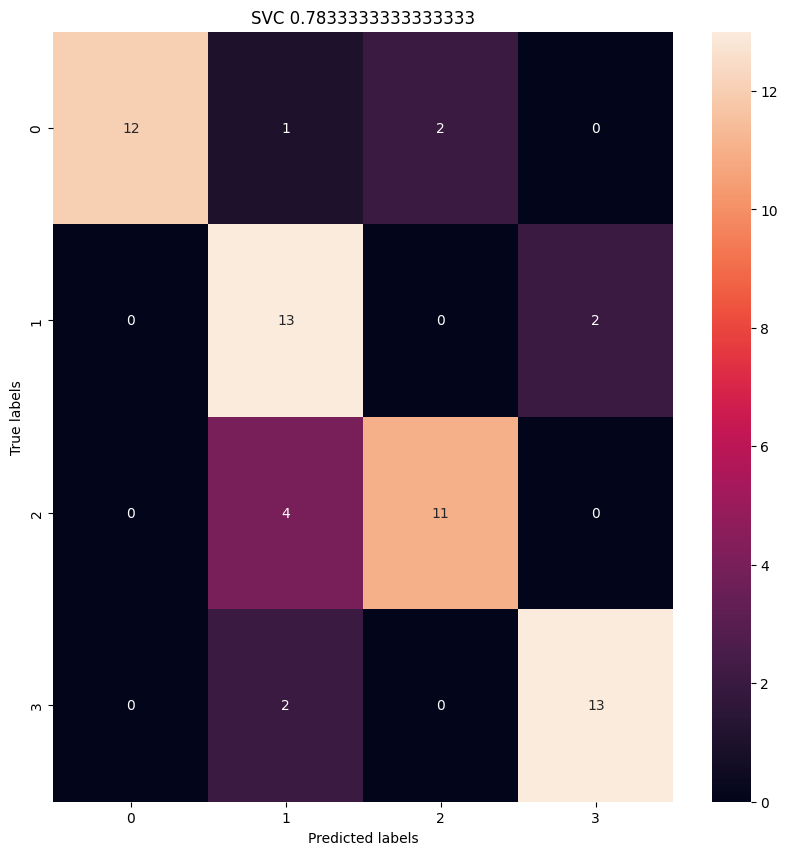

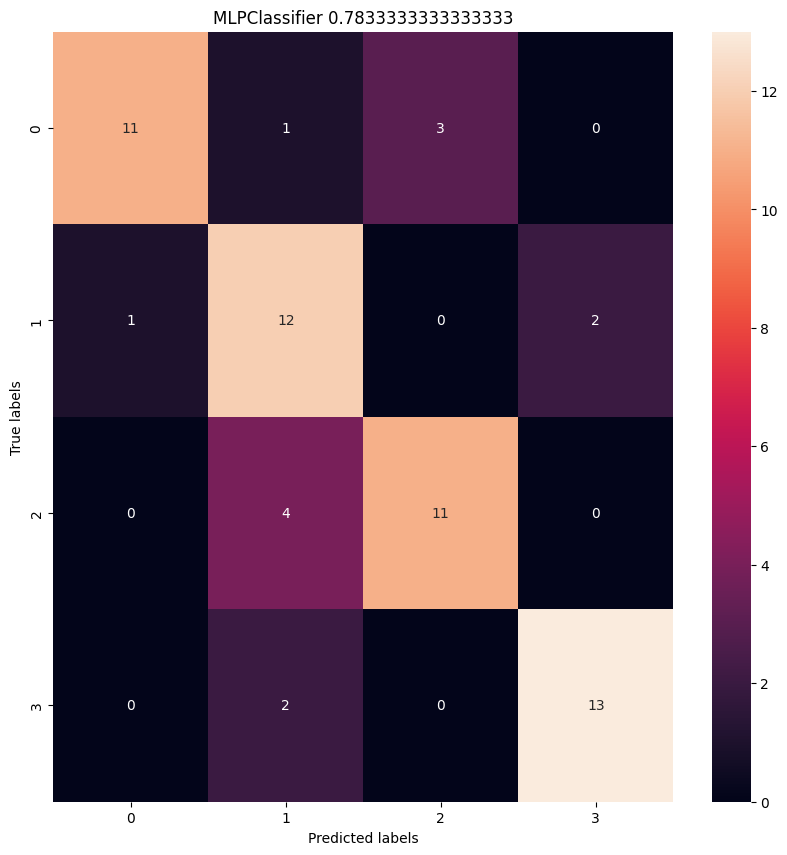

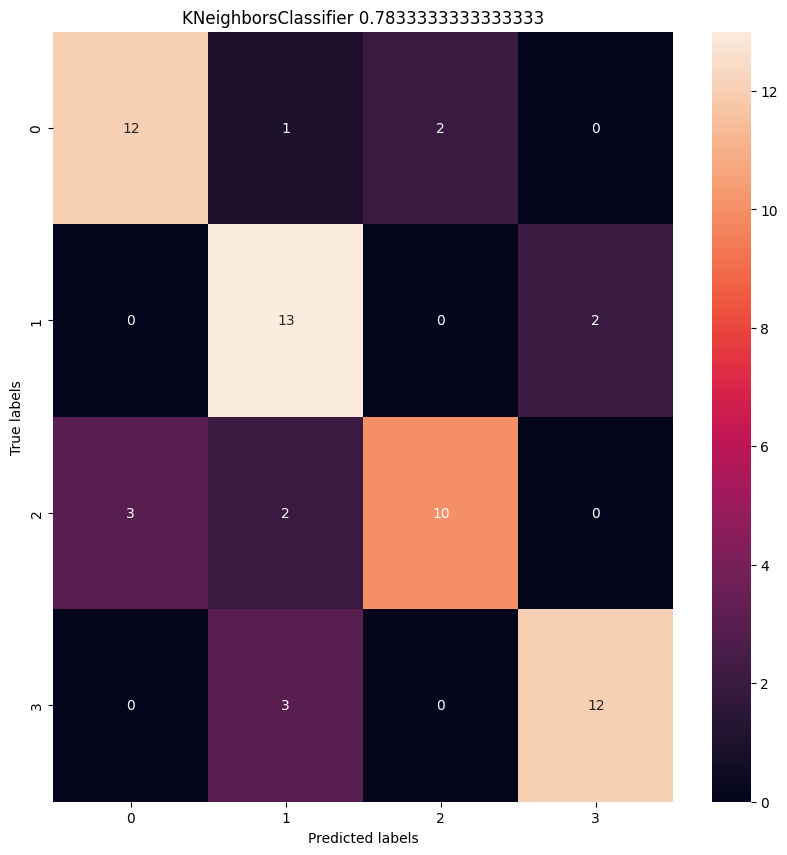

In [18]:
for clf in classifiers:
    y_pred = clf.predict(test_data)
    cm = confusion_matrix(test_labels, y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f"{clf.__class__.__name__} {score}")
    plt.show()